In [1]:
#Import Necessary Libraries
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import numpy as np # linear algebra
get_ipython().system('pip install spacy')
get_ipython().system('pip install wordcloud')
import spacy
#get_ipython().system('python -m spacy download en_core_web_sm')
#get_ipython().system('python -m  spacy link en_core_web_sm en --force')
#nlp = spacy.load('en')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
nltk.download('vader_lexicon')
stopwords = stopwords.words('english')
sns.set_context('notebook')
get_ipython().system('python -m spacy download en_core_web_lg')
get_ipython().system('python -m  spacy link en_core_web_lg en --force')
nlp = spacy.load('en')
import nltk
nltk.download('punkt')
import heapq
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
#Apply TfidfVectorizer to review text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Linking successful
/opt/conda/lib/python3.6/site-packages/en_core_web_lg -->
/opt/conda/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [13]:
#Data Pre Processing Function
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>Â©', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")


def remove_stopwords(sen):
    sen_new = " ".join([i for i in sen if i not in stop_words])
    return sen_new
   

punctuations = '!"#$%&\'()*+,-/:;<=>?@[\\]^_`{|}~Â©'
# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)

#Data Summarize Function
def generate_summary(text_without_removing_dot, cleaned_text):
    sample_text = text_without_removing_dot
    doc = nlp(sample_text)
    sentence_list=[]
    for idx, sentence in enumerate(doc.sents): # we are using spacy for sentence tokenization
        sentence_list.append(re.sub(r'[^\w\s]','',str(sentence)))

    stopwords = nltk.corpus.stopwords.words('english')

    word_frequencies = {}  
    for word in nltk.word_tokenize(cleaned_text):  
        if word not in stopwords:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1


    maximum_frequncy = max(word_frequencies.values())

    for word in word_frequencies.keys():  
        word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)


    sentence_scores = {}  
    for sent in sentence_list:  
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_frequencies.keys():
                if len(sent.split(' ')) < 30:
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                    else:
                        sentence_scores[sent] += word_frequencies[word]


    summary_sentences = heapq.nlargest(10, sentence_scores, key=sentence_scores.get)

    summary = ' '.join(summary_sentences)
    return text_without_removing_dot,summary
    #print("Original Text:\n")
    #print(text_without_removing_dot)
    # print('\n\nSummarized text:\n')
    #print(summary)

#Sentiment Analysis Function

def sentiment_analysis(text):
        """Performs a sentiment analysis on the tweet"""
        text1=text
        sid = SentimentIntensityAnalyzer()
        compound = sid.polarity_scores(text1)["compound"]

        if compound >= 0.5:
            return compound, "positive"
        elif compound <= -0.5:
            return compound, "negative"
        else:
            return compound, "neutral"

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [49]:
#Define Main function containing all the steps for execution
def main():
    reviews =pd.read_csv("/kaggle/input/Reviews.csv",nrows=10000)
    reviews.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
    reviews.dropna(axis=0,inplace=True)#dropping na
    reviews=reviews.reset_index(drop=True)
    
    reviews['Text_Cleaned_1'] = reviews['Text'].apply(normalize_text)
    reviews['Text_Cleaned'] = reviews['Text_Cleaned_1'].apply(lambda x: cleanup_text(x, False))
    
    #Summarizing text
    sum_text=[]
    for i in range(len(reviews['Text'])):
        #print(i)
        orig_text,pred_summ=generate_summary(reviews['Text'][i], reviews['Text_Cleaned'][i])
        t=(orig_text,pred_summ)
        sum_text.append(t)
    df_sum = pd.DataFrame(sum_text) 
    df_sum = pd.DataFrame(sum_text) 
    df_sum.rename(columns={0: "Orig_Text", 1: "Pred_Summ"}, inplace=True)
    # get summarized reviews into a list
    docs_test=df_sum['Pred_Summ'].tolist()
    #create a vocabulary of words, 
    #ignore words that appear in 85% of documents, 
    #eliminate stop words
    cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
    word_count_vector=cv.fit_transform(docs_test)
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    # Need to do this once, this is a mapping of index to 
    feature_names=cv.get_feature_names() 
    t=[]
    for i in range(len(df_sum)):
        #generate tf-idf for the given document
        tf_idf_vector=tfidf_transformer.transform(cv.transform([docs_test[i]]))
        #sort the tf-idf vectors by descending order of scores
        sorted_items=sort_coo(tf_idf_vector.tocoo())
        #extract only the top n; n here is 10
        keywords=extract_topn_from_vector(feature_names,sorted_items,10)
        t2=[]
        for k in keywords:
            t1=(k,keywords[k])
            t2.append(t1)
        t.append(t2)
    df_sum['Keywords']=t
    df_sum.to_csv('Prod_Review_Summarize.csv')
    print(" Summarize Text Completed")
    
    
    #Sentiment Analyzer on Summary Text
    lst=[]
    len(df_sum['Orig_Text'])
    
    for i in range(len(df_sum['Pred_Summ'])):
        sample_review = str(df_sum['Pred_Summ'][i:i+1].values)
        #print(sample_review)
        
        t_score,t_sent=sentiment_analysis(sample_review)
        #print(sample_review,sentiment_analysis(sample_review))
        t=(t_score,t_sent)
        #print(t)
        lst.append(t)

    df_temp=pd.DataFrame(lst)
    df_sum['Pred_Score']=df_temp[0]
    df_sum['Pred_Sent']=df_temp[1]
    
    #Top 10 Comments
    df_top_1=df_sum[df_sum['Pred_Sent']=='positive']
    df_top_2 = df_top_1.sort_values('Pred_Score', ascending=False)
    df_top10=pd.DataFrame()
    df_top10['Pred_Score']=df_top_2['Pred_Score'].head(10)
    df_top10['Pred_Summ']=df_top_2['Pred_Summ'].head(10)
    df_top10=df_top10.reset_index(drop=True)
    df_top10.to_csv('Top_10_Comments.csv')
    print(" Top 10 Comments Completed")
    #Worse 10 Comments
    df_top_3=df_sum[df_sum['Pred_Sent']=='negative']
    df_top_4 = df_top_3.sort_values('Pred_Score', ascending=True)
    df_top_4['Pred_Summ'].head(10).to_csv('Worse_10_Comm.csv')
    df_bot10=pd.DataFrame()
    df_bot10['Pred_Score']=df_top_4['Pred_Score'].head(10)
    df_bot10['Pred_Summ']=df_top_4['Pred_Summ'].head(10)
    df_bot10=df_bot10.reset_index(drop=True)
    df_bot10.to_csv('Buttom_10_Comments.csv')
    print(" Buttom 10 Comments Completed")
    # Sentiment Analysis Plot
    labels = 'Negative', 'Neutral', 'Positive'
    sizes = df_sum.groupby(df_sum['Pred_Sent'])['Orig_Text'].count().to_list()
    colors = ['lightcoral', 'gold', 'yellowgreen']
    explode = (0.1, 0, 0)  # explode 1st slice

    # Plot
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)

    plt.axis('equal')
    plt.show()
    plt.savefig('pred_sentiment.png')
    print(" Sentiment plot Completed")
    #Top10 Words

    
    # remove short words (length < 3)
    df_sum['Pred_Summ'] = df_sum['Pred_Summ'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    # remove stopwords from the text
    reviews = [remove_stopwords(r.split()) for r in df_sum['Pred_Summ']]
    model = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5)
    vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                                 ngram_range=(1, 2), 
                                 stop_words='english')
    vectorizer.fit(reviews)
    X_train = vectorizer.transform(reviews)
    vocab = vectorizer.get_feature_names()
    sse_err = []
    res = model.fit(X_train)
    vocab = np.array(vocab)
    cluster_centers = np.array(res.cluster_centers_)
    sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
    words=set()
    for i in range(len(res.cluster_centers_)):
        words = words.union(set(vocab[sorted_vals[i][-10:]]))
    words=list(words)
    print(words)

 Summarize Text Completed
 Top 10 Comments Completed
 Buttom 10 Comments Completed


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:80: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


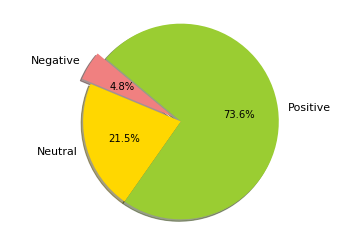

 Sentiment plot Completed
['food', 'price', 'really', 'flavors', 'good', 'bag', 'coffee', 'best', 'dont', 'chips', 'great', 'flavor', 'favorite', 'sweet', 'use', 'taste', 'better', 'like', 'tea', 'drink', 'cup', 'love', 'amazon', 'product']


<Figure size 432x288 with 0 Axes>

In [50]:
#Invoke Main
if __name__== "__main__":
     main()

In [51]:
!ls

Buttom_10_Comments.csv	   Top_10_Comments.csv	__notebook_source__.ipynb
Prod_Review_Summarize.csv  Worse_10_Comm.csv	pred_sentiment.png


In [54]:
from IPython.display import FileLink
FileLink(r'Buttom_10_Comments.csv')

/kaggle/working/Buttom_10_Comments.csv